# PPO两种形式：
### 1、PPO-惩罚：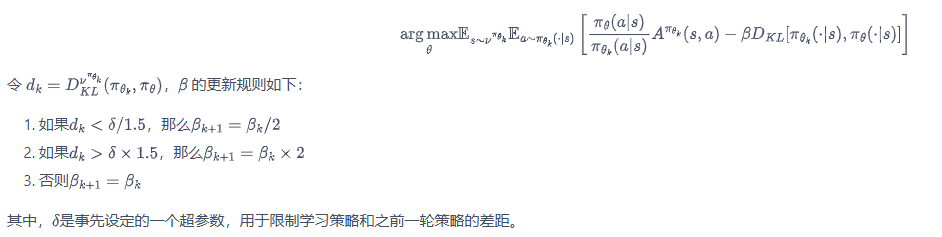
### 2、PPO-截断（表现更好）：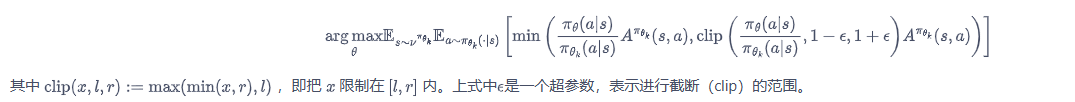

In [1]:
# PPO (Proximal Policy Optimization) 算法实现
# PPO是一种策略梯度方法，通过限制策略更新的幅度来提高训练稳定性

import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    """
    策略网络 - 用于输出动作概率分布
    在PPO中，策略网络负责根据当前状态选择动作
    """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        # 第一层：状态维度 -> 隐藏层维度
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        # 第二层：隐藏层维度 -> 动作维度
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        # 通过ReLU激活函数的隐藏层
        x = F.relu(self.fc1(x))
        # 输出动作概率分布（使用softmax确保概率和为1）
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    """价值网络 - 用于估计状态价值函数V(s)
    在Actor-Critic框架中，价值网络作为Critic评估状态的好坏
    """
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        # 第一层：状态维度 -> 隐藏层维度
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        # 第二层：隐藏层维度 -> 1（价值标量）
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # 通过ReLU激活函数的隐藏层
        x = F.relu(self.fc1(x))
        # 输出状态价值
        return self.fc2(x)


class PPO:
    """PPO算法实现，采用截断方式
    PPO的核心思想是限制策略更新的幅度，避免因为更新步长过大导致性能崩塌
    """
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        # 初始化策略网络（Actor）
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化价值网络（Critic）
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        
        # 优化器设置
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        # PPO算法参数
        self.gamma = gamma          # 折扣因子，用于计算未来奖励的现值
        self.lmbda = lmbda         # GAE（广义优势估计）中的λ参数
        self.epochs = epochs       # 每次收集数据后的训练轮数
        self.eps = eps            # PPO截断参数，控制策略更新幅度
        self.device = device

    def take_action(self, state):
        """根据当前状态选择动作
        使用策略网络输出的概率分布进行采样
        """
        # 将状态转换为tensor并添加batch维度
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        # 获取动作概率分布
        probs = self.actor(state)
        # 创建分类分布并采样动作（策略梯度类算法（比如 REINFORCE、PPO、A2C）里用来“ 按概率分布采样动作 ”的典型写法。）
        action_dist = torch.distributions.Categorical(probs)
        # 举例：如果 probs = [0.1, 0.7, 0.2]，那 70% 概率采到动作 1，10% 概率采到动作 0，20% 概率采到动作 2。
        action = action_dist.sample() 
        # .item() 把 0 维张量转成 Python 标量（int），方便和 Gym 环境交互。
        return action.item()

    def update(self, transition_dict):
        """PPO算法的核心更新函数
        使用收集到的经验数据更新策略网络和价值网络
        """
        # 将经验数据转换为tensor
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        # 计算TD目标值：r + γ * V(s') * (1 - done)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        
        # 计算TD误差：TD目标 - 当前状态价值
        td_delta = td_target - self.critic(states)
        
        # 使用GAE计算优势函数
        # 优势函数衡量某个动作相对于平均水平的好坏程度
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        
        # 计算旧策略的对数概率（用于重要性采样比率）-不变
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        # PPO的多轮更新（同一批数据更新多次网络参数）
        for _ in range(self.epochs):
            # 计算当前策略的对数概率-会变化
            log_probs = torch.log(self.actor(states).gather(1, actions))
            
            # 计算重要性采样比率：π_new(a|s) / π_old(a|s)
            ratio = torch.exp(log_probs - old_log_probs)
            
            # PPO的两个目标函数
            # surr1: 标准策略梯度目标
            surr1 = ratio * advantage
            # surr2: 截断版本，限制比率在[1-ε, 1+ε]范围内
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            
            # 策略网络损失函数/PPO损失函数：取两个目标的最小值（保守更新）后的平均值
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            
            # 价值网络损失：均方误差
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            
            # 更新策略网络
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            # 更新价值网络
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
# ============ 离散动作空间的PPO训练示例 ============

# 超参数设置
actor_lr = 1e-3      # 策略网络学习率
critic_lr = 1e-2     # 价值网络学习率
num_episodes = 500   # 训练回合数
hidden_dim = 128     # 隐藏层维度
gamma = 0.98         # 折扣因子
lmbda = 0.95         # GAE参数
epochs = 10          # 每次数据收集后的训练轮数
eps = 0.2           # PPO截断参数

# 设备选择
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 环境设置
env_name = 'CartPole-v0'
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)

# 获取环境信息
state_dim = env.observation_space.shape[0]  # 状态维度
action_dim = env.action_space.n             # 动作维度

# 创建PPO智能体
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

# 开始训练
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# 训练过程输出示例：
# Iteration 0: 100%|██████████| 50/50 [00:10<00:00,  4.81it/s, episode=50, return=183.200]
# Iteration 1: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s, episode=100, return=191.400]
# ... (训练过程中回合奖励逐渐提高)

d:\anaconda3\envs\DRL\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
迭代 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\23671\AppData\Local\Temp\ipykernel_45968\1182503793.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\bld\libtorch_1744320460695\work\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
d:\anaconda3\envs\DRL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
迭代 9: 100%|██████████| 50/50 [00:01<00:00, 29.71it/s, episode=500, return=200.000]


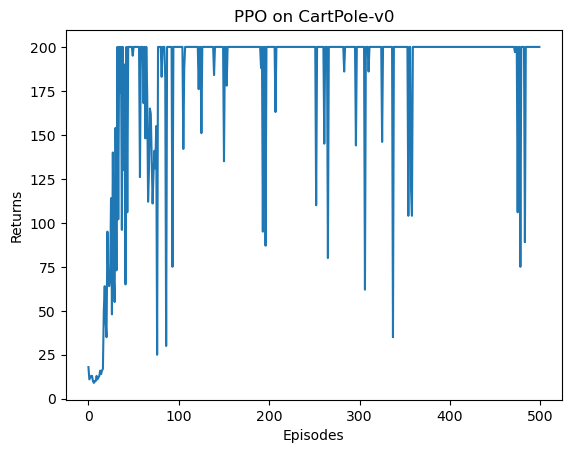

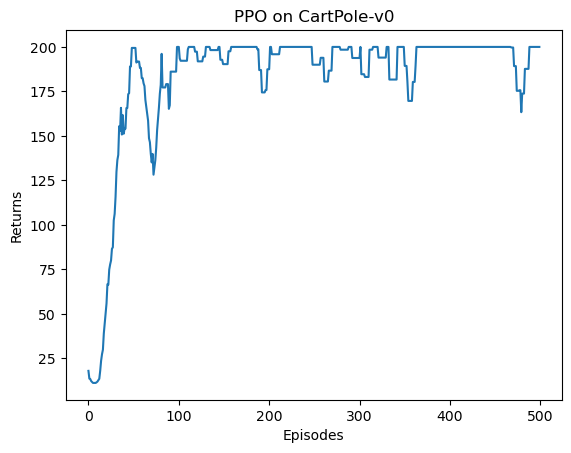

In [3]:
# ============ 训练结果可视化 ============

# 绘制原始训练结果
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

# 绘制移动平均结果（平滑曲线）
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [4]:
# ============ 连续动作空间的PPO实现 ============

class PolicyNetContinuous(torch.nn.Module):
    """连续动作空间的策略网络
    输出动作的均值和标准差，用于构建正态分布
    """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        # 输出动作均值的网络层
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        # 输出动作标准差的网络层
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # 动作均值，使用tanh限制在[-2, 2]范围内
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        # 动作标准差，使用softplus确保为正值
        std = F.softplus(self.fc_std(x))
        return mu, std


class PPOContinuous:
    """处理连续动作的PPO算法
    与离散版本的主要区别在于动作采样和概率计算方式
    """
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        # 连续动作的策略网络
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        # 价值网络与离散版本相同
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        """连续动作采样
        从正态分布中采样动作
        """
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        # 创建正态分布并采样
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        """连续动作PPO更新
        主要区别在于概率密度函数的计算
        """
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        # 奖励重塑，便于训练
        rewards = (rewards + 8.0) / 8.0
        
        # TD目标和优势计算与离散版本相同
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        
        # 计算旧策略下的对数概率
        mu, std = self.actor(states)
        # 创建正态分布
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        old_log_probs = action_dists.log_prob(actions)

        # 多轮更新
        for _ in range(self.epochs):
            mu, std = self.actor(states)
            # torch.distributions.Normal 是创建正态分布
            action_dists = torch.distributions.Normal(mu, std) 
            # log_prob(): 计算动作在该分布下的对数概率密度
            log_probs = action_dists.log_prob(actions)
            
            # 重要性采样比率
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            
            # PPO损失
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            
            # 网络更新
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

# 连续动作空间的改造：让策略网络输出连续动作高斯分布（Gaussian distribution）的均值和标准差。后续的连续动作则在该高斯分布中采样得到。

迭代 9: 100%|██████████| 100/100 [00:03<00:00, 30.68it/s, episode=1000, return=-323.403]


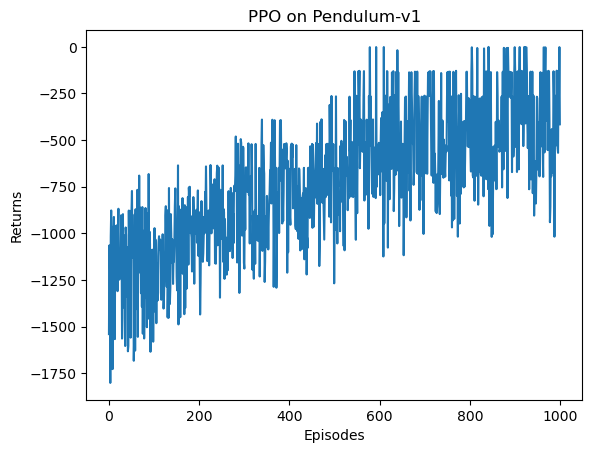

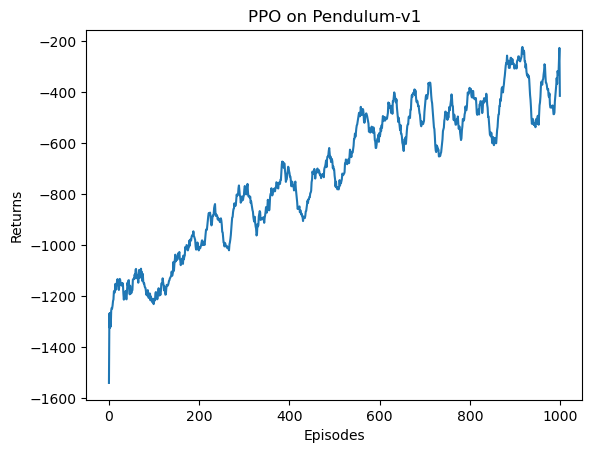

In [5]:
# ============ 连续动作空间训练示例 ============

# 连续动作环境的超参数
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2

# 倒立摆环境（连续动作）
env_name = 'Pendulum-v1'
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间

# 创建连续动作PPO智能体
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

# 训练
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# 结果可视化
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()